In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<hr>

## Imports

In [10]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from matplotlib import image
import glob
import cv2
import os
import zipfile
import pyarrow as pa
import pyarrow.parquet as pq
import gc
import time
import sys

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import timeit

base_path = pathlib.Path('/content/drive/MyDrive/W207/Data/')

<hr>

## Helper Methods

In [3]:
def timeit(f):
    def wrap(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        print(f'func:{f.__name__} args:[{args}, {kw}] took: {te-ts:2.4f} sec')        
        return result
    return wrap

<hr>

## Load Data

In [6]:
@timeit
def load():
  path = base_path / 'X_train.pq'
  table = pq.read_table(str(path))
  table = table.to_pandas().to_numpy()
  return table

X_train = load()
y_train = np.array(pd.read_csv(base_path / 'X_labels.csv'))

func:load args:[(), {}] took: 55.7307 sec


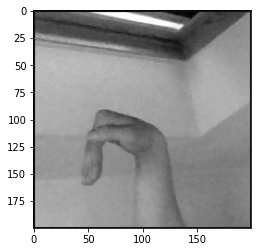

In [7]:
plt.rc('image', cmap='gray')
plt.imshow(X_train[5].reshape(200,200))
plt.show()

<hr>

## Preprocessing 

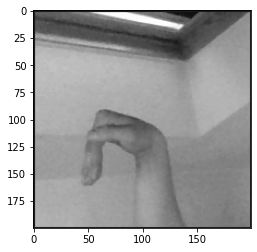

In [56]:
def remove_background(img, threshold):
    """
    This method removes background from your image
    
    :param img: cv2 image
    :type img: np.array
    :param threshold: threshold value for cv2.threshold
    :type threshold: float
    :return: RGBA image
    :rtype: np.ndarray
    """
    gray = img
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshed = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

    cnts = cv2.findContours(morphed, 
                            cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)[0]

    cnt = sorted(cnts, key=cv2.contourArea)[-1]

    mask = cv2.drawContours(threshed, cnt, 0, (0, 255, 0), 0)
    masked_data = cv2.bitwise_and(img, img, mask=mask)

    x, y, w, h = cv2.boundingRect(cnt)
    dst = masked_data[y: y + h, x: x + w]
    return dst
    # dst_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(dst_gray, 0, 255, cv2.THRESH_BINARY)
    b, g, r = cv2.split(dst)

    rgba = [r, g, b, alpha]
    dst = cv2.merge(rgba, 4)

    return dst

image = remove_background(X_train[5].reshape(200,200), threshold=250)
plt.imshow(image)
plt.show()

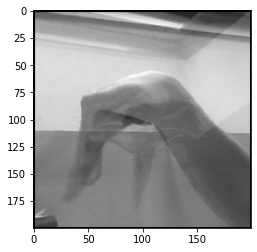

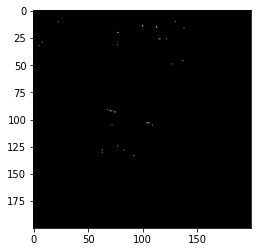

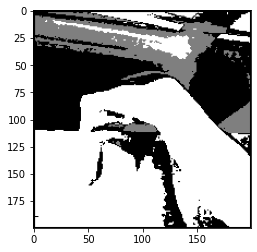

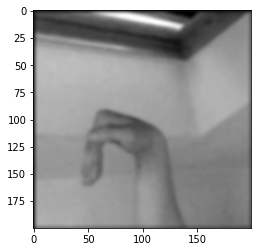

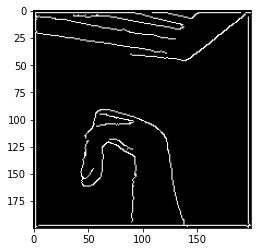

In [63]:
image = X_train[5].reshape(200,200)

backSub = cv2.createBackgroundSubtractorMOG2()
for index in range(10):
  backSub.apply(X_train[index].reshape(200,200))
background = backSub.getBackgroundImage()

plt.imshow(background)
plt.show()
fore = np.absolute(X_train[5].reshape(200,200) - background)
fgmask = backSub.apply(X_train[5].reshape(200,200), learningRate=0)
plt.imshow(fgmask)
plt.show()


backSub2 = cv2.createBackgroundSubtractorMOG2()
backSub2.apply(background)
fgmask = backSub2.apply(image, learningRate=0)
plt.imshow(fgmask)
plt.show()


blur_image = cv2.GaussianBlur(image, (7,7), 0)
plt.imshow(blur_image)
plt.show()


edge_img = cv2.Canny(blur_image,10,100)
plt.imshow(edge_img)
plt.show()

In [32]:
# X_train = np.array(X_train)
# y_train = np.array(y_train)
labels = list(set(y_train.tolist()))
examples = np.array(X_train)
num_examples = 1

# Create empty list to add digit example indexes to
image_index_list = []
# use list comprehension to identify indexes of digits 0-9 and add to a list called image_index_list
[image_index_list.extend(list(np.where(y_train==labels[label])[0][:num_examples])) for label in range(len(labels))]
image_index_list = sorted(image_index_list)

plt.rc('image', cmap='gray')
fig, ax = plt.subplots(6, 5, figsize=(25,25))
# Setting counter to be used for image index
counter = 0

for i in range(6):
    for num in range(5):
        if counter < len(image_index_list): #27:
            ind = image_index_list[counter]
            # Displaying image on correct subplot
            ax[i, num].imshow(X_train[ind].reshape(200,200))
            # remove axises
            ax[i,num].axis('off')
            # Printing titles above each digit
            ax[i,num].set_title('ASL: '+y_train[ind]+' Example')
            counter+=1
plt.axis('off')
plt.show()

SyntaxError: ignored

In [ ]:
#Shuffle the dataset
X_train,y_train = shuffle(X_train,y_train,random_state=18)

In [ ]:
# train test split to
x_train,x_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.2)

<hr>

## Naive Bayes

In [ ]:
# Using the Multinomial Naive Bayes, fit and predict, and generate f1 score.    
def mnb_score(alpha, train_vectors, dev_vectors):
    clf = MultinomialNB(alpha=alpha)
    clf.fit(train_vectors, train_labels)
    dev_pred = clf.predict(dev_vectors)
    score = metrics.f1_score(dev_labels, dev_pred, average='weighted')
    return (alpha, score)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None, var_smoothing=1e-09)

<hr>

## Logistic Regression

<hr>

## Convolutional Neural Networks